In [4]:
import torch
import pandas
import torchtext
import numpy as np
from torchtext import data
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot
from pytorch_metric_learning import losses
from collections import Counter
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from reimsiam import SiamNet
import json
from reimsiam import Poetry_Datatset
from pytorch_metric_learning.distances import CosineSimilarity
from sklearn.model_selection import train_test_split

In [5]:
df = pandas.read_csv("reims_pairs.csv")
print(df.shape)
df = df[~(df.word_1.isnull()|df.word_2.isnull())]
print(df.shape)
train_df, test_df = train_test_split(df, test_size=0.1)

(1092572, 3)
(1092554, 3)


In [6]:
df.isnull().sum()

Unnamed: 0    0
word_1        0
word_2        0
dtype: int64

In [7]:
word_counter = Counter()
word_counter.update(train_df.word_1)
word_counter.update(train_df.word_2)

In [8]:
a = []
length_counter = Counter()
for word in train_df.word_1:
    #a.append(str(type(word)))
    length_counter.update([len(word)])
    #length_counter.update([word])
for word in train_df.word_2:
    length_counter.update([len(word)])
    #length_counter.update([word])

    

In [9]:
# Генерирует отрицательные примеры 
def n_sampl_gen(dataset, word_counter, smplnum=5):
    freqs = np.array([count for word, count in word_counter.most_common()])
    words = [word for word, count in word_counter.most_common()]
    rel_probs = freqs/freqs.sum()
    indxs = np.arange(len(rel_probs))
    while True:
        n_samples = []
        subsample = np.random.choice(indxs, p=rel_probs, size=smplnum)
        for indx in subsample:
            n_samples.append(dataset.convert_sample(words[indx]))
        yield torch.stack(n_samples, 0)

In [10]:
with open("hyperparams.json", "r") as f:
    hyperparams = json.load(f)

model_state_name = "Siamnet_params_omnistanza"

num_neg = hyperparams["numnegs"]

batch_size = 50

#2 датасета - для тренироваки и теста
positive_dataset = Poetry_Datatset(train_df)
test_positive_dataset = Poetry_Datatset(test_df)

torch.save(positive_dataset.vocab, "letters_vocab_omnistanza")
hyperparams["model_name_omnistanza"] = model_state_name
hyperparams["letters_vocab_omnistanza"] = "letters_vocab_omnistanza"
with open("hyperparams.json", "w") as f:
    json.dump(hyperparams, f)


positive_data_loader = DataLoader(positive_dataset, batch_size=batch_size, shuffle=True)
test_positive_data_loader = DataLoader(test_positive_dataset, batch_size=batch_size, shuffle=False)


neg_gen = n_sampl_gen(positive_dataset, word_counter, smplnum=num_neg*batch_size)
test_neg_gen = n_sampl_gen(test_positive_dataset, word_counter, smplnum=num_neg*batch_size)

In [11]:
hyperparams

{'numnegs': 3,
 'maxlen': 10,
 'model_name': 'Siamnet_params',
 'model_name_final': 'reims_gen_final',
 'words_vocab': 'words_vocab',
 'letters_vocab': 'letters_vocab',
 'model_name_omnistanza': 'Siamnet_params_omnistanza',
 'letters_vocab_omnistanza': 'letters_vocab_omnistanza'}

In [12]:
loss = losses.ContrastiveLoss(pos_margin=1, neg_margin=0, distance=CosineSimilarity())


In [13]:
torch.cuda.is_available()

True

In [14]:
def gen_target_vector(batch_size, num_neg):
    start = num_neg * batch_size
    targets = [i for i in range(start, start+batch_size)] *2 
    targets += [x for x in range(num_neg*batch_size)]
    return torch.LongTensor(targets)

In [15]:
gen_target_vector(batch_size, num_neg)

tensor([150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
        164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
        178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191,
        192, 193, 194, 195, 196, 197, 198, 199, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183,
        184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197,
        198, 199,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
         12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
         40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
         68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  

In [19]:
model = SiamNet(vocab_size=len(positive_dataset.vocab))
model.to(torch.device("cuda"))
targets = gen_target_vector(batch_size, num_neg)
targets = targets.to(torch.device("cuda"))
optimizer = torch.optim.Adam(model.parameters())
loss_values = [] 
test_losses = [] 
epoch_num = 50
best_loss = 10000000000
best_epoch = -1


with tqdm(total=int(len(positive_dataset)/batch_size) * epoch_num) as progress_bar_1:
    for epoch in range(epoch_num):
        model.train()
        batch_loss = []
        test_epoch_loss = 0
        print("Epoch number : ", epoch)
        with tqdm(total=int(len(positive_dataset)/batch_size)) as progress_bar_2:
            for (words1, words2) in positive_data_loader:
                neg_s = next(neg_gen)
                input_ids = torch.cat((words1, words2, neg_s))
                progress_bar_1.update(1)
                progress_bar_2.update(1)
                if len(input_ids) != batch_size * (2 + num_neg):
                    continue
                input_ids = input_ids.to(torch.device("cuda"))
                output = model(input_ids)
                cost = loss(output, targets)
                cost.backward()
                optimizer.step()
                optimizer.zero_grad()
                batch_loss.append(cost.item())
            loss_values.append(sum(batch_loss))
        model.eval()
        with tqdm(total=int(len(test_positive_dataset)/batch_size)) as progress_bar_3:
            for (words1, words2) in test_positive_data_loader:
                neg_s = next(test_neg_gen)
                input_ids = torch.cat((words1, words2, neg_s))
                progress_bar_3.update(1)
                if len(input_ids) != batch_size * (2 + num_neg):
                    continue
                input_ids = input_ids.to(torch.device("cuda"))
                output = model(input_ids)
                test_cost = loss(output, targets)
                test_epoch_loss += test_cost.item()
        test_losses.append(test_epoch_loss)
        
        
        if test_epoch_loss < best_loss:
            best_loss = test_epoch_loss
            best_epoch = epoch
            torch.save(model.state_dict(), model_state_name)
            print("Best epoch so far : ", epoch)
            
        if (epoch - best_epoch) >= 5:
            break
              


Epoch number :  0



Best epoch so far :  0
Epoch number :  1



Best epoch so far :  1
Epoch number :  2



Epoch number :  3



Epoch number :  4



Best epoch so far :  4
Epoch number :  5



Epoch number :  6



Best epoch so far :  6
Epoch number :  7



Epoch number :  8



Epoch number :  9



Epoch number :  10



Epoch number :  11


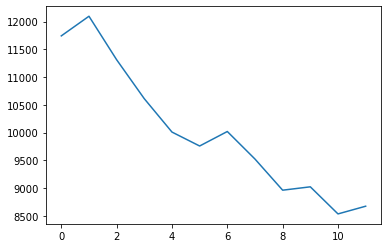

In [25]:
plt.plot(loss_values) 


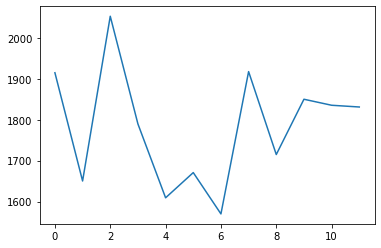

In [24]:
plt.plot(test_losses) 

In [ ]:
special